In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import os

In [2]:

class DataSetPart:
    def __init__(self):
        self.y = []
        self.x = []
        pass

class DataSet:
    def __init__(self, path, scaled=True, pca_components=None, class_name="CLASS"):
        features = ['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode',
                    'Mean', 'Median', 'Variance', 'Tendency', 'CLASS', 'NSP']
        df = pd.read_csv(path, sep=',', header=1, skiprows=0, skipinitialspace=True, engine='python')
        df = df[features]
        self.df = df
        
        self.train = DataSetPart()
        self.test = DataSetPart()

        from sklearn.model_selection import train_test_split
        for c in np.unique(df[class_name].values):
            rows = df[df[class_name]==c].values[:, 0:-2]
            x_train, x_test, y_train, y_test = train_test_split(rows, np.full(len(rows), c), test_size=0.2, random_state=42)
            self.train.x.extend(x_train)
            self.train.y.extend(y_train)
            self.test.x.extend(x_test)
            self.test.y.extend(y_test)
        
        self.train.x = np.array(self.train.x)
        self.train.y = np.array(self.train.y)
        self.test.x = np.array(self.test.x)
        self.test.y = np.array(self.test.y)

        if pca_components:
            from sklearn.decomposition import PCA
            pca = PCA(n_components=pca_components)
            pca.fit(self.train.x)
            self.train.x = pca.transform(self.train.x)
            self.test.x = pca.transform(self.test.x)

        if scaled:
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            scaler.fit(self.train.x)
            self.train.x = scaler.transform(self.train.x)
            self.test.x = scaler.transform(self.test.x)


In [3]:
d = DataSet("./CTG.csv") 
d.df.head()


LB        AC   FM        UC        DL   DS   DP  ASTV  MSTV  ALTV ...   \
0  120  0.000000  0.0  0.000000  0.000000  0.0  0.0    73   0.5    43 ...    
1  132  0.006380  0.0  0.006380  0.003190  0.0  0.0    17   2.1     0 ...    
2  133  0.003322  0.0  0.008306  0.003322  0.0  0.0    16   2.1     0 ...    
3  134  0.002561  0.0  0.007682  0.002561  0.0  0.0    16   2.4     0 ...    
4  132  0.006515  0.0  0.008143  0.000000  0.0  0.0    16   2.4     0 ...    

   Max  Nmax  Nzeros  Mode  Mean  Median  Variance  Tendency  CLASS  NSP  
0  126     2       0   120   137     121        73         1      9    2  
1  198     6       1   141   136     140        12         0      6    1  
2  198     5       1   141   135     138        13         0      6    1  
3  170    11       0   137   134     137        13         1      6    1  
4  170     9       0   137   136     138        11         1      2    1  

[5 rows x 23 columns]

In [4]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np
from collections import defaultdict

MAX_ITER = 1000 # kernel='poly' takes too long to calculate, set some max number of iterations
import warnings
warnings.filterwarnings('ignore', 'Solver terminated early*')

# kernel from {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ }
# gamma from {'auto', 'scale'}
# decision_function_shape from {'ovo', 'ovr'}
def train_svm(dataset, kernel='rbf', gamma='auto', decision_function_shape='ovr', C=1, max_iter=MAX_ITER):
    clf = svm.SVC(gamma=gamma, kernel=kernel, C=C, decision_function_shape=decision_function_shape, max_iter=max_iter)
    score = cross_val_score(clf, dataset.train.x, dataset.train.y, cv=5, scoring='accuracy') 

    clf2 = svm.SVC(gamma=gamma, kernel=kernel, C=C, decision_function_shape=decision_function_shape, max_iter=max_iter)
    clf2.fit(dataset.train.x, dataset.train.y)
    test_y = clf2.predict(dataset.test.x)
    test_score = accuracy_score(dataset.test.y, test_y)

    return score, test_score, clf2

def search_svm_kernel(dataset, max_iter=MAX_ITER, decision_function_shape='ovr'):
    from sklearn import svm
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import accuracy_score

    d = {}
    for kernel in ['rbf', 'linear', 'poly', 'sigmoid']:
        clf = svm.SVC(gamma='auto', kernel=kernel, max_iter=max_iter)
        score = cross_val_score(clf, dataset.train.x, dataset.train.y, cv=5, scoring='accuracy')
        d[kernel] = '({}: {} +- {}: {}) '.format(kernel, score.mean(), score.std(), score)
    for _, v in d.items():
        print(v)


def grid_search_svm(dataset, kernel='linear', decision_function_shape='ovr'):
    from sklearn.model_selection import GridSearchCV
    from sklearn import svm
    import pandas as pd

    parameters = {'C':[0.3, 0.5, 1, 2, 10, 50, 100, 200 , 600, 1200, 3000, 6000, 10000, 20000, 30000, 40000, 80000, 100000, 200000, 400000], 
                  'gamma':[0.0001, 0.0012, 0.0025, 0.0037, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.35, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0]}

    svc = svm.SVC(kernel=kernel, max_iter=MAX_ITER, decision_function_shape=decision_function_shape)
    clf = GridSearchCV(svc, parameters, cv=5, n_jobs=4, return_train_score=True, iid=False)

    clf.fit(dataset.train.x, dataset.train.y)
    df = pd.DataFrame.from_dict(clf.cv_results_)
    df = df.sort_values(by='rank_test_score')
    print('best mean_test_score: ', df['mean_test_score'].values[0:5])
    print('best param_C: ', df['param_C'].values[0:5])
    print('best param_gamma', df['param_gamma'].values[0:5])
    return df


In [5]:
from sklearn import naive_bayes as nb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

def train_nb(dataset):
    clf = nb.GaussianNB()
    score = cross_val_score(clf, dataset.train.x, dataset.train.y, cv=5, scoring='accuracy')

    clf2 = nb.GaussianNB()
    clf2.fit(dataset.train.x, dataset.train.y)
    test_y = clf2.predict(dataset.test.x)
    test_score = accuracy_score(dataset.test.y, test_y)

    return score, test_score



In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

def train_knn(dataset, k=3):
    clf = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(clf, dataset.train.x, dataset.train.y, cv=5, scoring='accuracy') 

    clf2 = KNeighborsClassifier(n_neighbors=k)
    clf2.fit(dataset.train.x, dataset.train.y)
    test_y = clf2.predict(dataset.test.x)
    test_score = accuracy_score(dataset.test.y, test_y)

    return score, test_score

In [7]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn import svm

class EnsambleClassifier:
    def fit(self, x, y, num_classifiers, create_classifier_fnc):
        sub_batch_size = int(len(y) * 0.7)
        clfs = []
        np.random.seed(42)
        for _ in range(num_classifiers):
            indices = np.random.randint(low=0, high=len(y), size=sub_batch_size)
            x_batch = x[indices, :]
            y_batch = y[indices]
            clf = create_classifier_fnc()
            clf.fit(x_batch, y_batch)
            clfs.append(clf)

        self.clfs = clfs
    
    def predict(self, datum, weights=None):
        votes = defaultdict(float)
        for i, clf in enumerate(self.clfs):
            c = clf.predict([datum])[0]
            weight = 1.0 if not weights else weights[i]
            votes[c] = votes[c] + weight
        maximum = max(votes, key=votes.get)
        return maximum
    
    def get_individual_accuracies(self, x, y):
        r = []
        for clf in self.clfs:
            y_pred = clf.predict(x)
            a = accuracy_score(y, y_pred)
            r.append(a)
        return r
    
    def accuracy(self, x, y, weights=None):
        y_pred = []
        for i in range(len(y)):
            datum = x[i, :] 
            y_pred.append(self.predict(datum, weights))
        return accuracy_score(y, y_pred)


def train_ensamble(dataset):
    def create_classifier():
        n = np.random.randint(low=0, high=10)
        if n < 2:
            k = np.random.randint(low=1, high=6)
            return KNeighborsClassifier(n_neighbors=k)
        else:
            parameters = {'C':[0.3, 0.5, 1, 2, 10, 50, 100, 200 , 600, 1200, 3000, 6000, 10000, 20000, 30000, 40000, 80000, 100000, 200000, 400000], 
                          'gamma':[0.0001, 0.0012, 0.0025, 0.0037, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.35, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0]}
            C = parameters['C'][np.random.randint(low=0, high=len(parameters['C']))]
            gamma = parameters['gamma'][np.random.randint(low=0, high=len(parameters['gamma']))]
            clf = svm.SVC(gamma=gamma, kernel='linear', C=C, decision_function_shape='ovo', max_iter=100000)
            return clf

    clf = EnsambleClassifier()
    num_classifiers = 50
    clf.fit(dataset.train.x, dataset.train.y, num_classifiers, create_classifier)
    weights = clf.get_individual_accuracies(dataset.train.x, dataset.train.y)
    weights = 1000 * weights
    weights = None # weights does not have any real impact
    return clf.accuracy(dataset.test.x, dataset.test.y, weights)


In [8]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def train_logistic_reg(dataset):
    clf = LogisticRegression(solver = 'lbfgs', class_weight="balanced")
    score = cross_val_score(clf, dataset.train.x, dataset.train.y, cv=5, scoring='accuracy') 

    clf2 = LogisticRegression(solver = 'lbfgs', class_weight="balanced")
    clf2.fit(dataset.train.x, dataset.train.y)
    test_y = clf2.predict(dataset.test.x)
    test_score = accuracy_score(dataset.test.y, test_y)

    return score, test_score


In [9]:
from sklearn.ensemble import RandomForestClassifier

def train_random_forest(dataset, n_estimators=100):
    clf = RandomForestClassifier(n_estimators=n_estimators, class_weight="balanced")
    score = cross_val_score(clf, dataset.train.x, dataset.train.y, cv=5, scoring='accuracy') 

    clf2 = RandomForestClassifier(n_estimators=n_estimators, class_weight="balanced")
    clf2.fit(dataset.train.x, dataset.train.y)
    test_y = clf2.predict(dataset.test.x)
    test_score = accuracy_score(dataset.test.y, test_y)

    return score, test_score


In [10]:
def printResult(score, score_test, name):
    print(' --- ', name, ' --- ')
    print('cross val: {}'.format(score))
    print('mean:      {:.2f}'.format(score.mean()))
    print('std:       {:.2f}'.format(score.std()))
    print('test_data: {0:.2f}'.format(score_test))
    print('')
    
from sklearn.decomposition import PCA

def plot_pca(preds, class_name):
    dpca = DataSet(path='./CTG.csv', pca_components=2, scaled=True, class_name=class_name)

    fig = plt.figure(figsize=(16,12))


    markers = ["x" if i == False else "o" for i in dpca.test.y==preds]

    x_ok = []
    y_ok = []
    x_wrong = []
    y_wrong = []

    for i,m in enumerate(markers):
        x = dpca.test.x[i]
        y = dpca.test.y[i]
        if m == "o":
            x_ok.append(x)
            y_ok.append(y)
        else:
            x_wrong.append(x)
            y_wrong.append(y)


    x_ok = np.array(x_ok)
    y_ok = np.array(y_ok)
    x_wrong = np.array(x_wrong)
    y_wrong = np.array(y_wrong)

    plt.scatter(x_ok[:,0], x_ok[:,1], s=60, facecolors='none', c=y_ok, marker="o")
    plt.scatter(x_wrong[:,0], x_wrong[:,1], s=80, facecolors='none', c=y_wrong, marker="x")

    plt.show()

import seaborn as sns
def plot_confusion(confusion):
    norm_confusion = confusion / confusion.sum(axis=1)
    plt.figure(figsize = (10,7))

    sns.set_style(style="white")
    sns.heatmap(confusion, annot=True)

In [11]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

def runTest(scale=True, pca_comps=False, class_name="CLASS"):

    d = DataSet(path='./CTG.csv', scaled=scale, pca_components=pca_comps, class_name=class_name)

    score_nb, score_test_nb = train_nb(d)
    score_knn, score_test_knn = train_knn(d, k=2)
    score_logr, score_test_logr = train_logistic_reg(d)
    score_rf, score_test_rf = train_random_forest(d)
    score_svm, score_test_svm, _ = train_svm(d, decision_function_shape='ovo')
    score_svm_best, score_test_svm_best, clf_svm = train_svm(d, decision_function_shape='ovo', kernel='linear', gamma=0.0037, C=2, max_iter=100000)
    score_test_ensamble = train_ensamble(d)
    print("training done")
    
    # << parameters from this:
    #from svm import search_svm_kernel
    #print('ovo:')
    #search_svm_kernel(dataset, max_iter=10000, decision_function_shape='ovo')
    #print('ovr')
    #search_svm_kernel(dataset, max_iter=10000, decision_function_shape='ovr')
    # -> 'linear', 'ovo'
    #from svm import grid_search_svm
    #grid_search_svm(dataset, decision_function_shape='ovo')
    # -> gamma and c parameters

    printResult(score_nb, score_test_nb, "naive bayes")
    printResult(score_knn, score_test_knn, "k-nearest neighbours")
    printResult(score_logr, score_test_logr, "logistic regression")
    printResult(score_rf, score_test_rf, "random forest")

    printResult(score_svm, score_test_svm, "SVM")
    printResult(score_svm_best, score_test_svm_best, "SVM best")
    print(" --- ensemble ---")
    print('test_data: {0:.2f}'.format(score_test_ensamble))
    
    preds = clf_svm.predict(d.test.x)
    
    plot_pca(preds, class_name=class_name)
    
    confusion = pd.crosstab(d.test.y, preds)

    plot_confusion(confusion)
    
    return clf_svm

training done
 ---  naive bayes  --- 
cross val: [0.55393586 0.51754386 0.51775148 0.49851632 0.56547619]
mean:      0.53
std:       0.03
test_data: 0.56

 ---  k-nearest neighbours  --- 
cross val: [0.73177843 0.69298246 0.74260355 0.72700297 0.72619048]
mean:      0.72
std:       0.02
test_data: 0.70

 ---  logistic regression  --- 
cross val: [0.79883382 0.77192982 0.77514793 0.79525223 0.80654762]
mean:      0.79
std:       0.01
test_data: 0.78

 ---  random forest  --- 
cross val: [0.89795918 0.84210526 0.83431953 0.88724036 0.86607143]
mean:      0.87
std:       0.02
test_data: 0.87

 ---  SVM  --- 
cross val: [0.8483965  0.77192982 0.79881657 0.82789318 0.82142857]
mean:      0.81
std:       0.03
test_data: 0.79

 ---  SVM best  --- 
cross val: [0.8483965  0.79532164 0.81360947 0.83679525 0.82738095]
mean:      0.82
std:       0.02
test_data: 0.82

 --- ensemble ---
test_data: 0.83


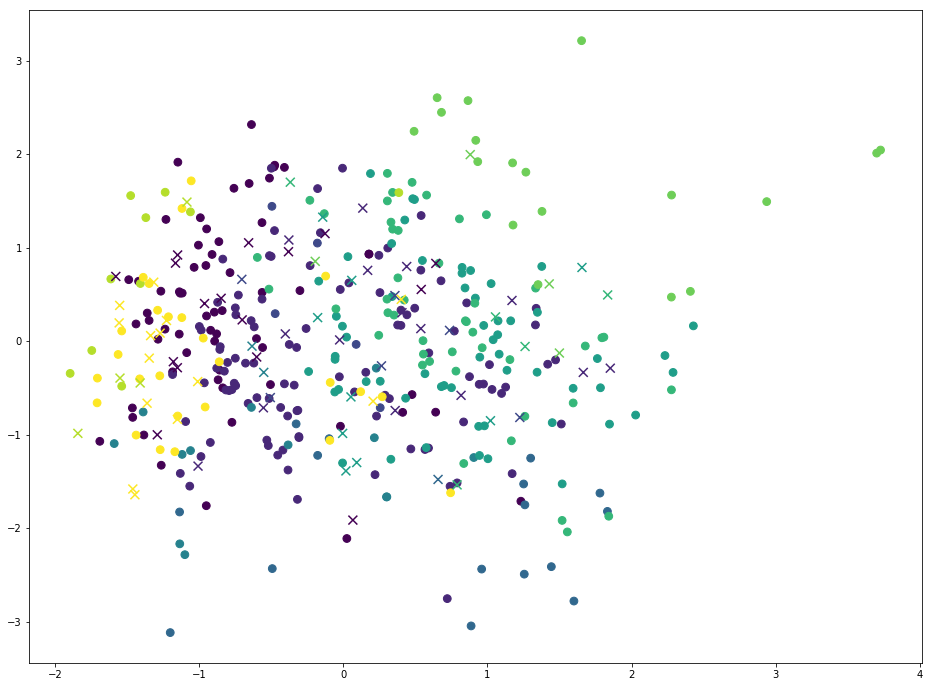

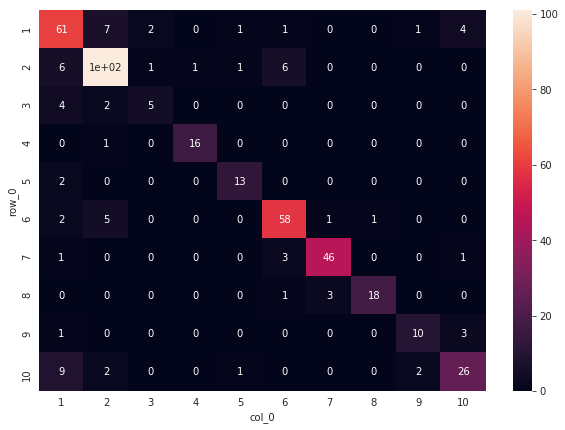

In [12]:

clf = runTest()


training done
 ---  naive bayes  --- 
cross val: [0.70967742 0.69411765 0.73823529 0.72058824 0.82300885]
mean:      0.74
std:       0.05
test_data: 0.75

 ---  k-nearest neighbours  --- 
cross val: [0.93255132 0.89117647 0.9        0.9        0.87020649]
mean:      0.90
std:       0.02
test_data: 0.91

 ---  logistic regression  --- 
cross val: [0.86803519 0.85294118 0.89117647 0.86176471 0.86135693]
mean:      0.87
std:       0.01
test_data: 0.88

 ---  random forest  --- 
cross val: [0.96480938 0.90588235 0.93529412 0.95       0.94690265]
mean:      0.94
std:       0.02
test_data: 0.93

 ---  SVM  --- 
cross val: [0.92668622 0.87352941 0.91176471 0.91764706 0.91150442]
mean:      0.91
std:       0.02
test_data: 0.92

 ---  SVM best  --- 
cross val: [0.92375367 0.87941176 0.9        0.90882353 0.89380531]
mean:      0.90
std:       0.01
test_data: 0.90

 --- ensemble ---
test_data: 0.90


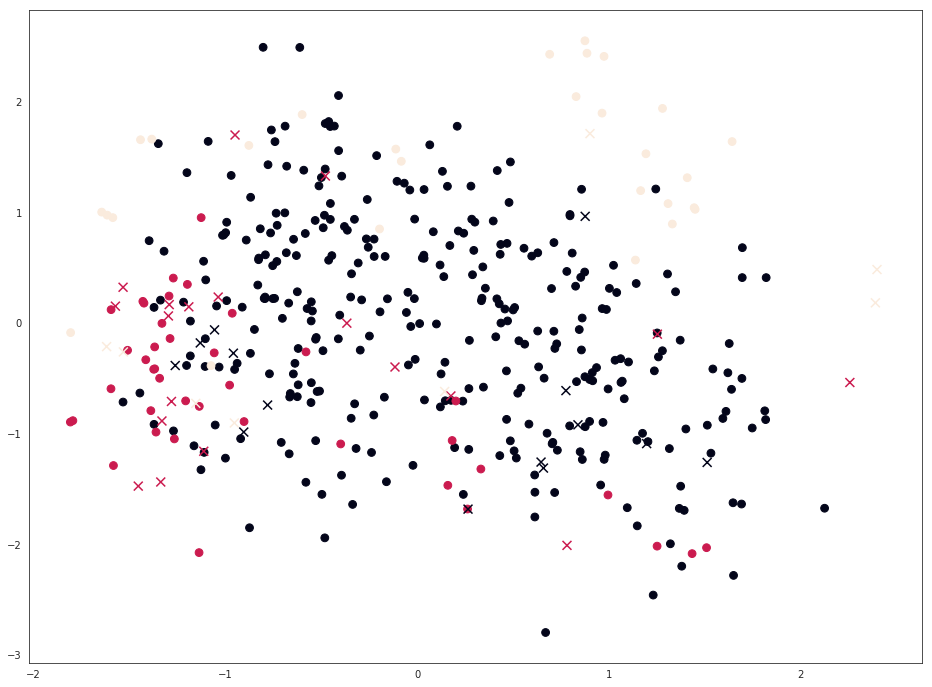

SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=0.0037, kernel='linear',
  max_iter=100000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

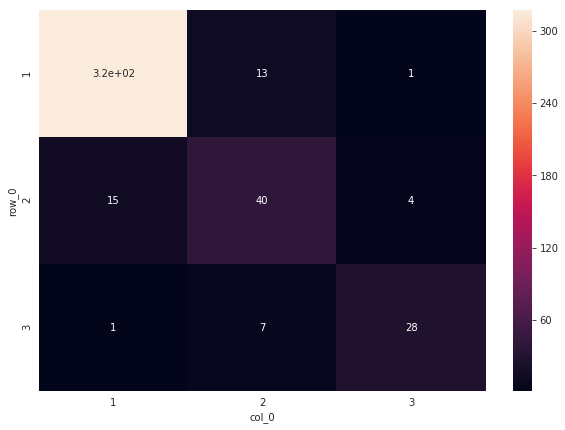

In [13]:
runTest(class_name="NSP")

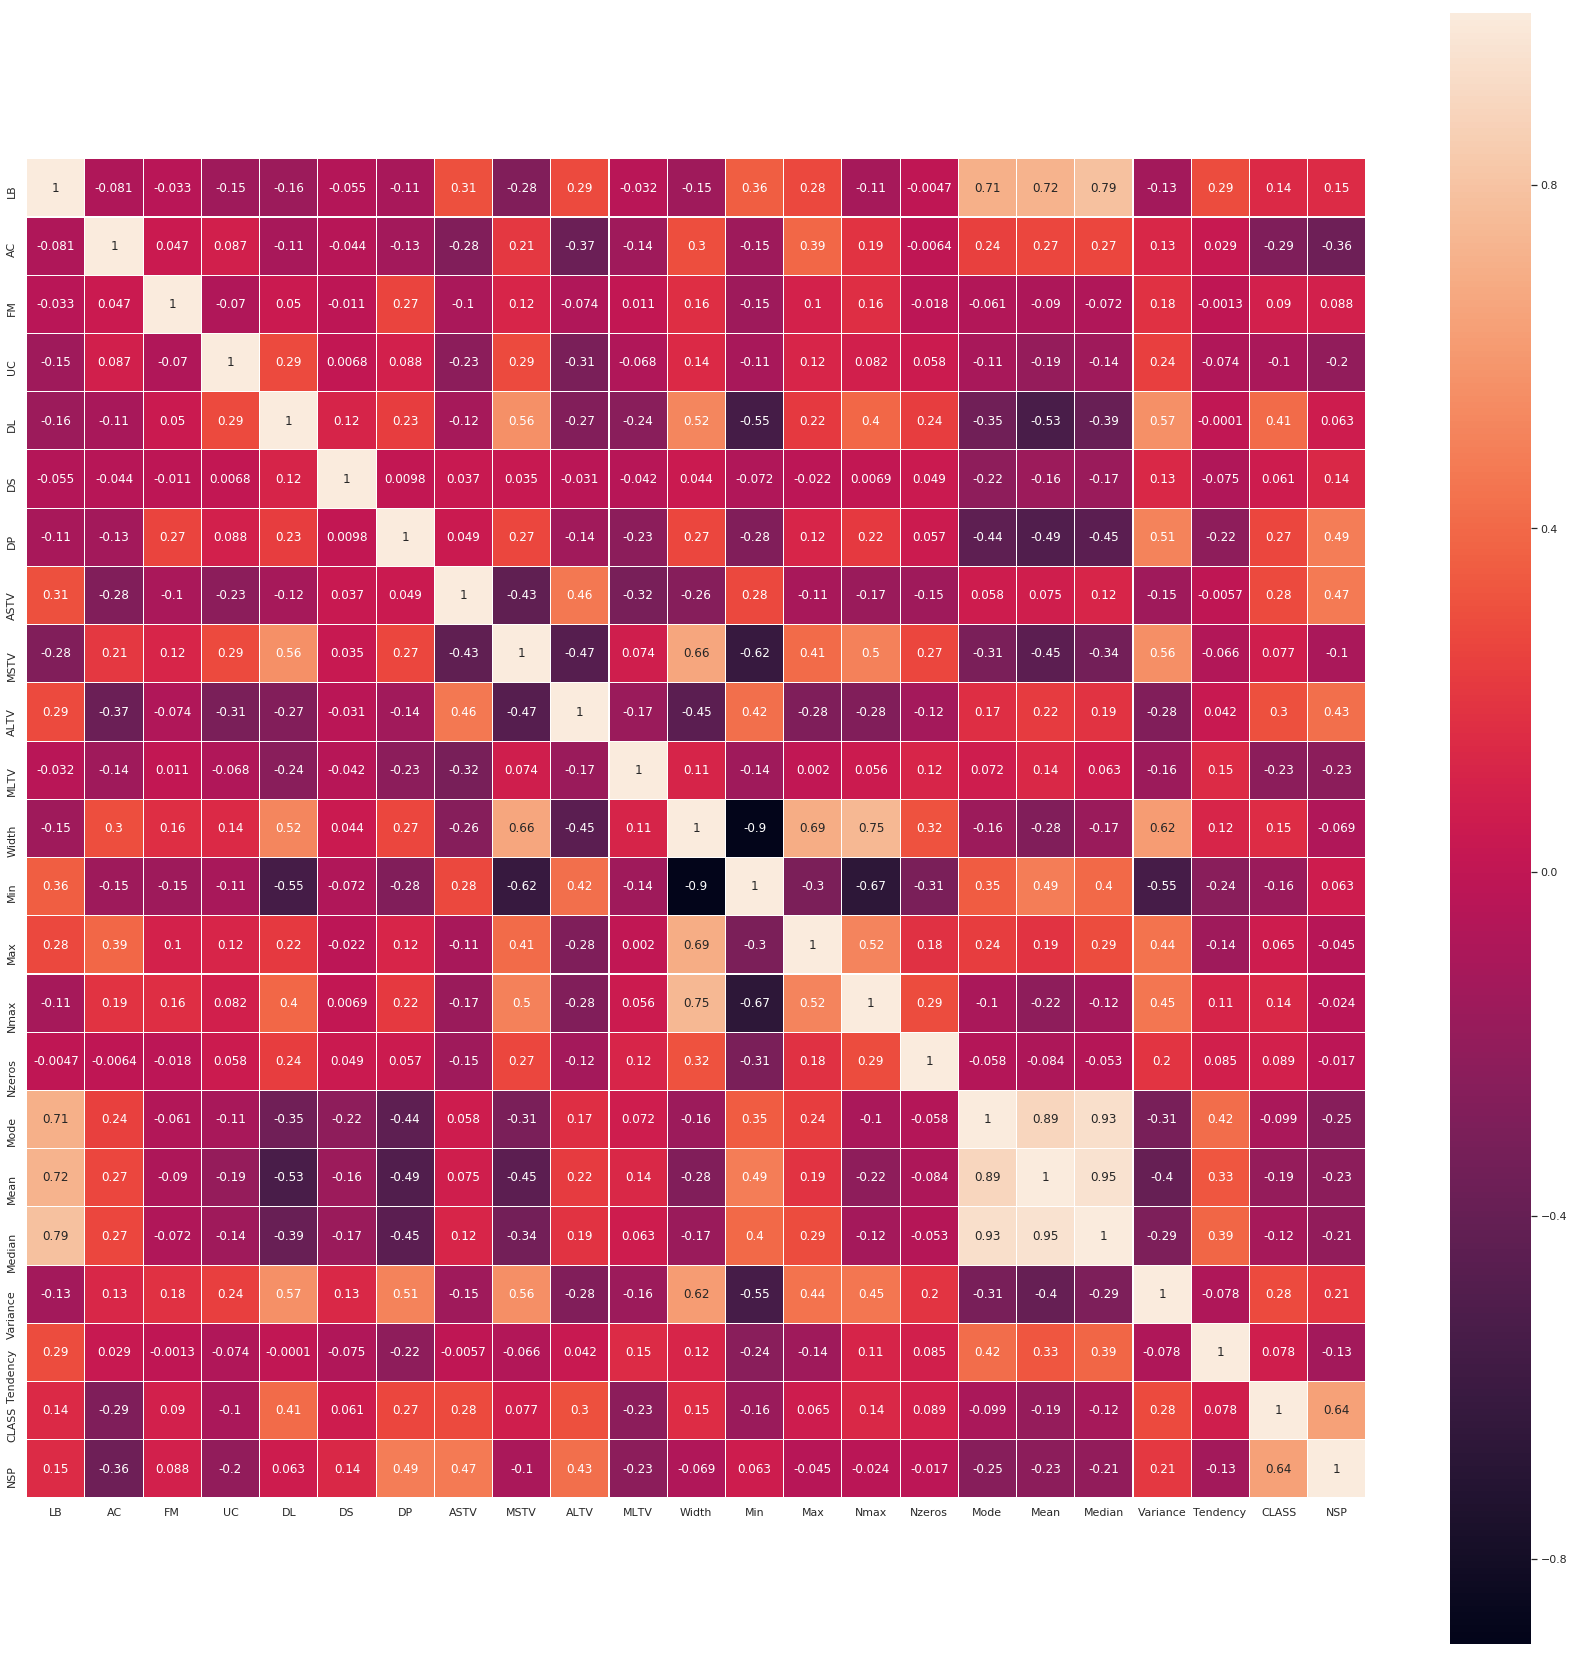

In [14]:
import seaborn as sns
sns.set(style=None, color_codes=True)
plt.figure(figsize=(30, 30))
sns.heatmap(d.df.astype(float).corr(), linewidths=0.1, square=True, linecolor="white", annot=True)
plt.show()